IMPORTING LIBRARIES

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error


DATA PREPARATION

In [ ]:
# Load the dataset
df = pd.read_csv("D://Downloads//maharashtra_2024_daily_energy_forecasting_dataset.csv", encoding='cp1252')

# 1. Convert 'Date' to datetime
df['Date'] = pd.to_datetime(df['Date'], dayfirst=True)

# 2.Rename misnamed columns (handling multiple possible names)
df.rename(columns={
    'Solar Radiation(W/m²)': 'Solar Radiation',
    'Solar Radiation(W/mA²)': 'Solar Radiation',
    'Wind Speed(km/h)': 'Wind Speed',
    'Wind Speed (km/h)': 'Wind Speed',
    'Temperature(C)': 'Temperature (°C)',
    'Humidity(%)': 'Humidity (%)',
    'Rainfall(mm)': 'Rainfall (mm)',
    'Cloud Cover(%)': 'Cloud Cover (%)',
}, inplace=True)

# 3. Feature Engineering: Add 'Month' and 'Weekday'
df['Month'] = df['Date'].dt.month
df['Weekday'] = df['Date'].dt.dayofweek  # 0 = Monday, 6 = Sunday

# 4.Check for missing values
missing_report = df.isnull().sum()
print(" Missing Values Report:\n", missing_report)

# Fill missing values (forward fill; can use mean/median if needed)
df.fillna(method='ffill', inplace=True)

# 5.Sanity check - Confirm correct datatypes and head
print(df.dtypes)
print(df.head())


 Missing Values Report:
 Date                        0
Day of Week                 0
Season                      0
City                        0
Load Type                   0
Temperature (Â°C)           0
Humidity (%)                0
Rainfall (mm)               0
Cloud Cover (%)             0
Wind Speed (m/s)            0
Solar Radiation (W/m²)      0
Wind Power (MW)             0
Solar Power (MW)            0
Hydro Power (MW)            0
Electric Load (MW)          0
Energy Consumption Trend    0
Month                       0
Weekday                     0
dtype: int64
Date                        datetime64[ns]
Day of Week                         object
Season                              object
City                                object
Load Type                           object
Temperature (Â°C)                  float64
Humidity (%)                       float64
Rainfall (mm)                      float64
Cloud Cover (%)                    float64
Wind Speed (m/s)                   

C:\Users\rah00\AppData\Local\Temp\ipykernel_16572\3579291964.py:28: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)


DATA VISUALIZATION

🔹 Correlation Heatmap

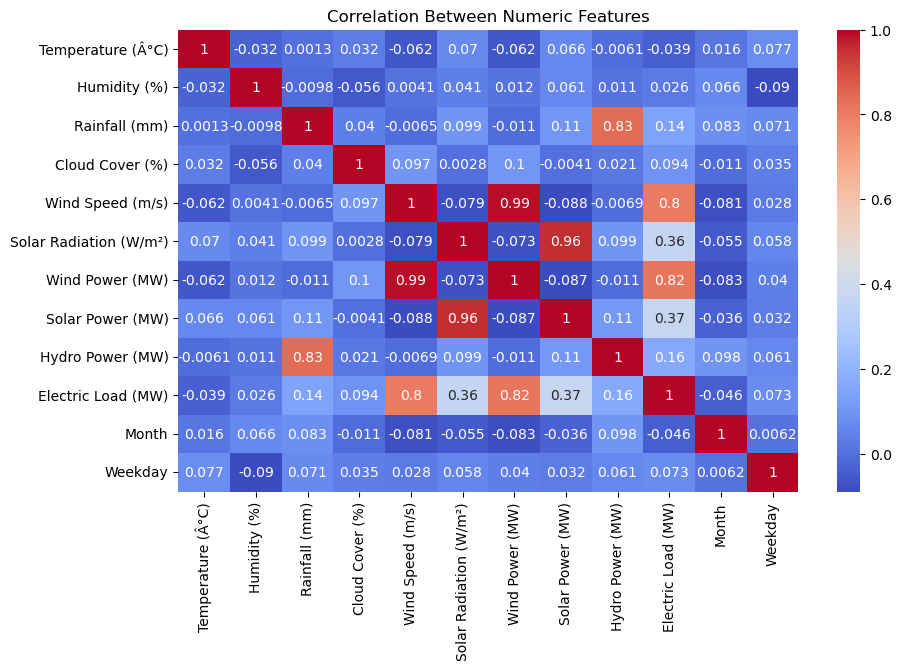

In [ ]:
# Select only numeric columns
numeric_df = df.select_dtypes(include=['number'])

# Plot heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(numeric_df.corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Between Numeric Features")
plt.show()


🔹 Total Renewable vs Electric Load Over Time

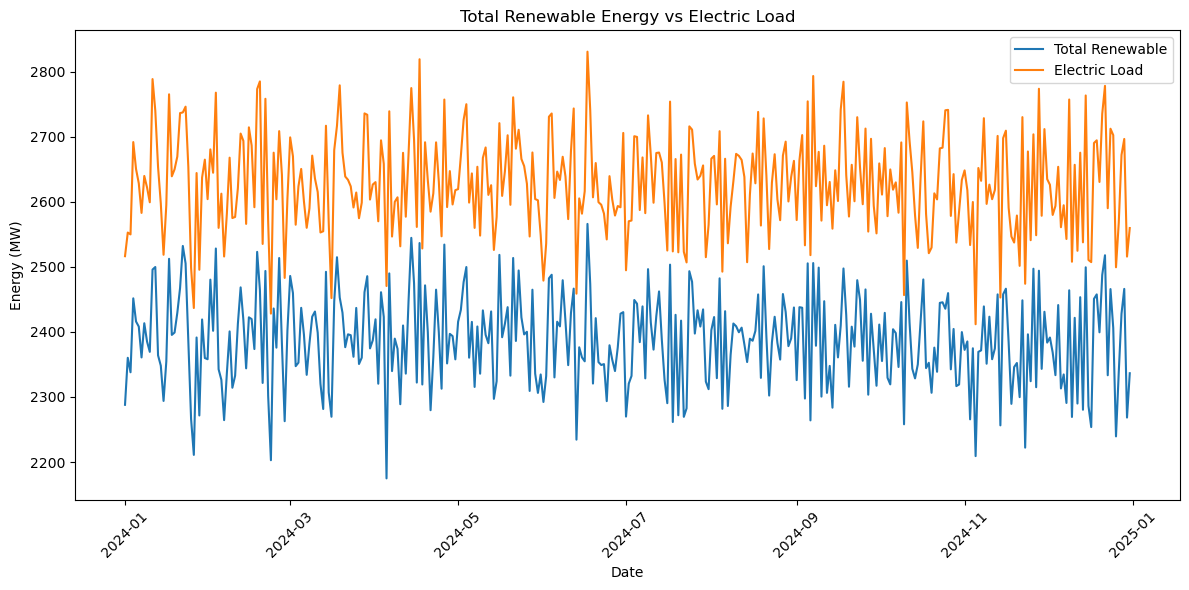

In [ ]:
df['Total Renewable'] = ( df['Solar Power (MW)'] + df['Wind Power (MW)'] + df['Hydro Power (MW)'])

plt.figure(figsize=(12, 6))
plt.plot(df['Date'], df['Total Renewable'], label='Total Renewable')
plt.plot(df['Date'], df['Electric Load (MW)'], label='Electric Load')
plt.legend()
plt.title("Total Renewable Energy vs Electric Load")
plt.xlabel("Date")
plt.ylabel("Energy (MW)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


🔹 Pairplot of Weather vs Energy

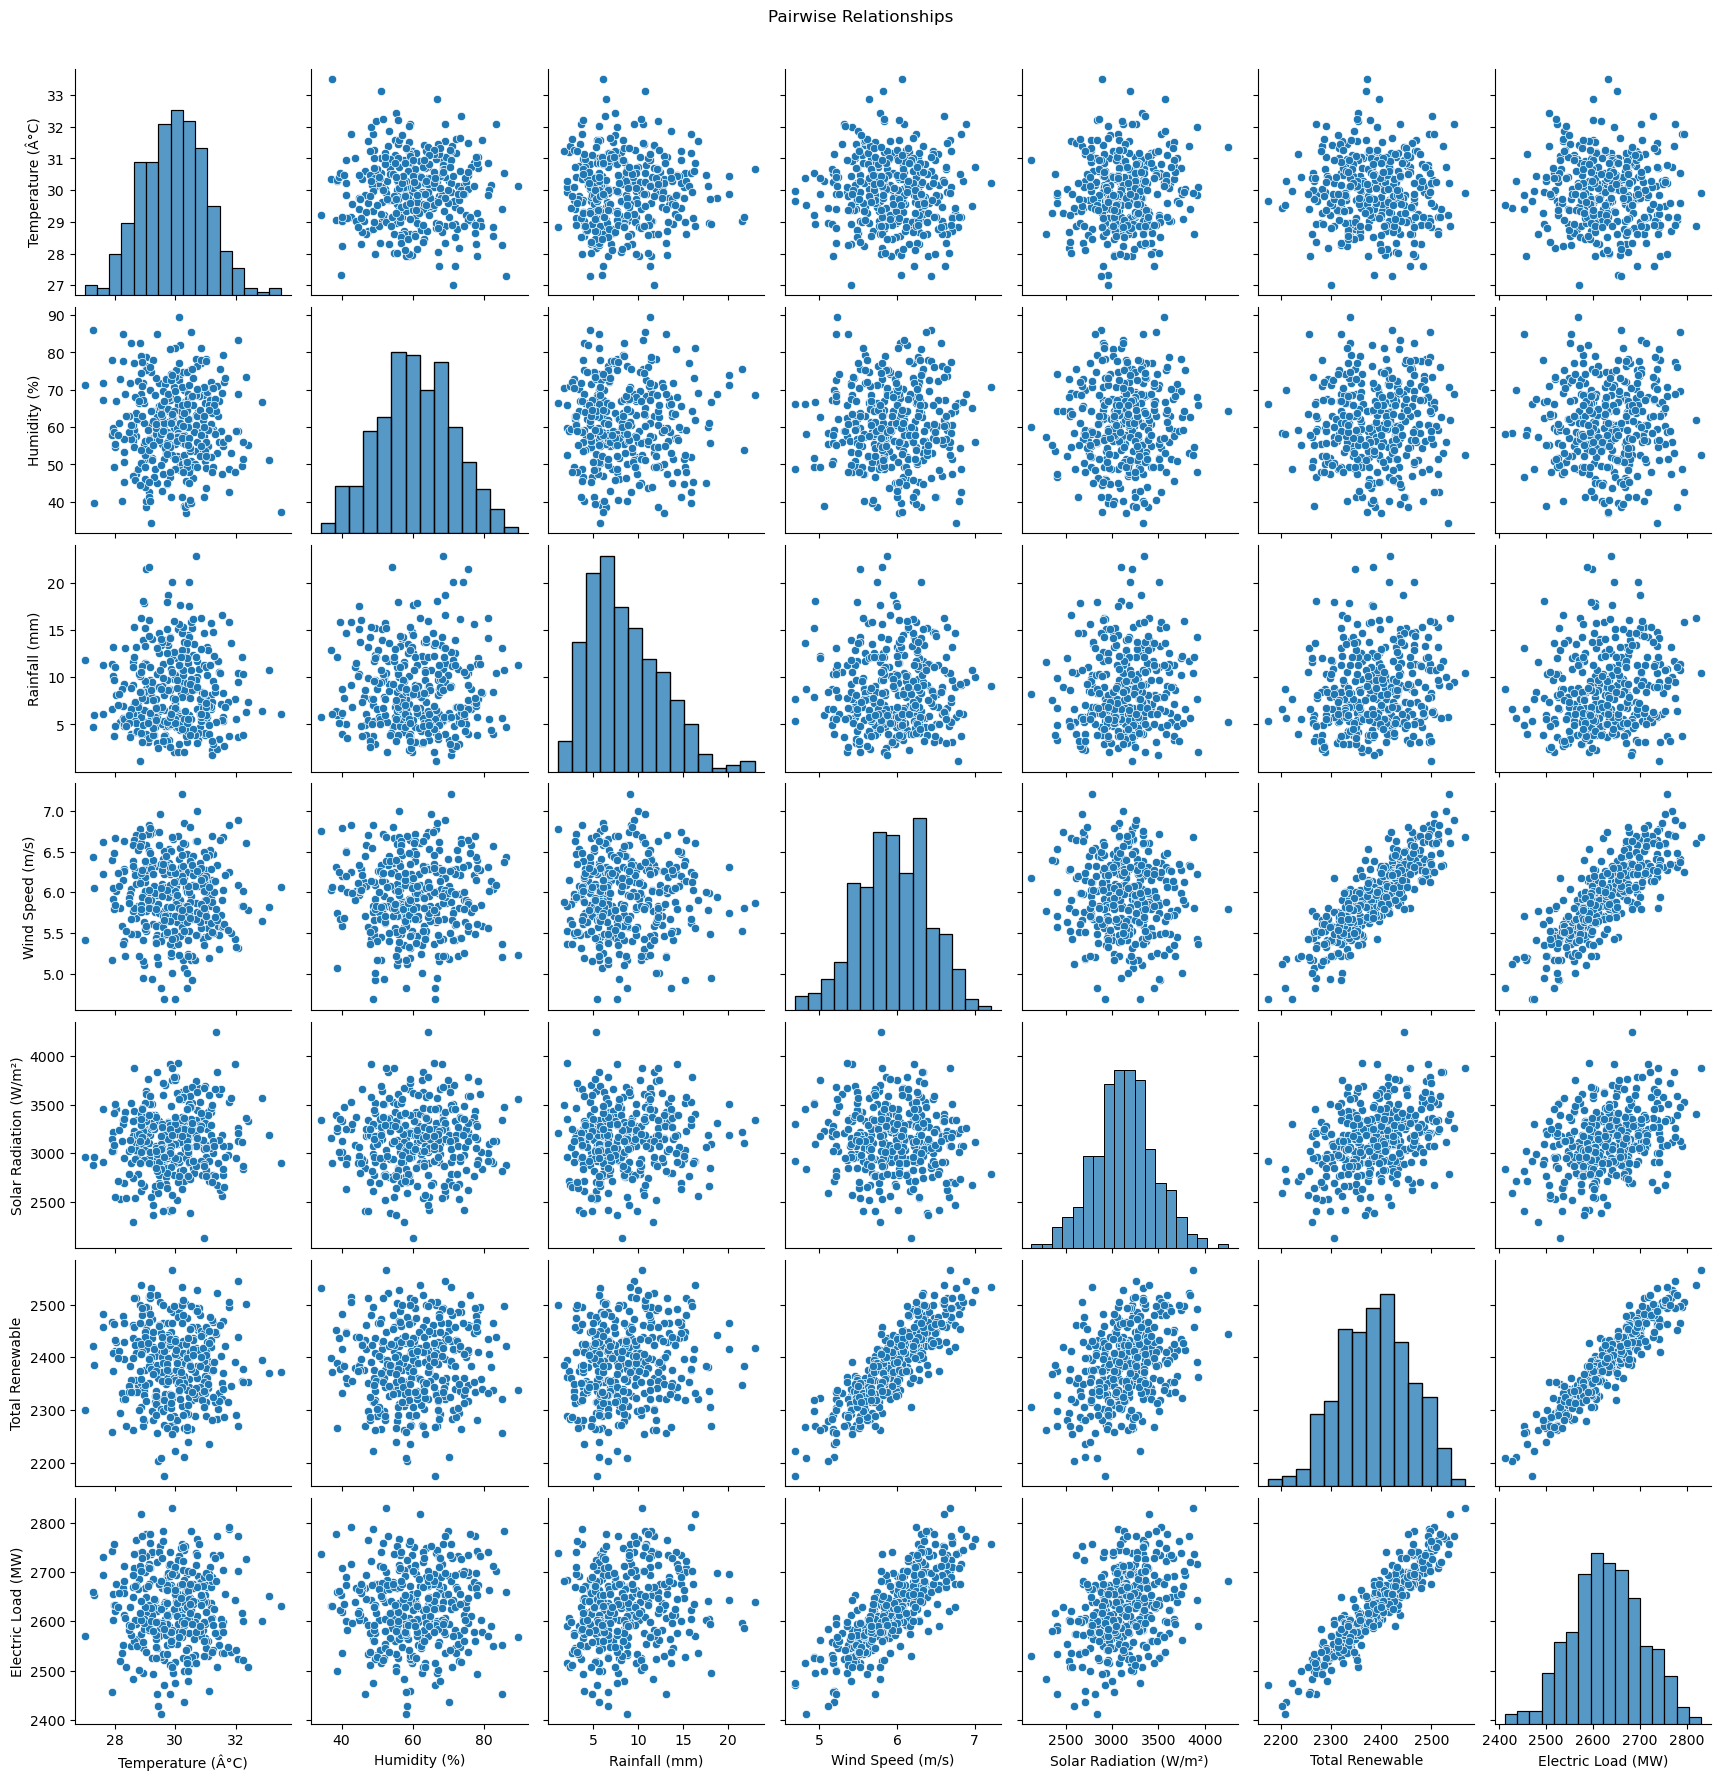

In [ ]:
sns.pairplot(df[['Temperature (Â°C)', 'Humidity (%)', 'Rainfall (mm)', 
                 'Wind Speed (m/s)', 'Solar Radiation (W/m²)', 
                 'Total Renewable', 'Electric Load (MW)']])
plt.suptitle("Pairwise Relationships", y=1.02)
plt.show()


4️⃣ MODEL A: Forecasting Total Renewable Energy

 Features & Target

In [ ]:
features_A = ['Temperature (Â°C)', 'Humidity (%)', 'Rainfall (mm)', 'Wind Speed (m/s)', 
              'Solar Radiation (W/m²)', 'Cloud Cover (%)', 'Month', 'Weekday']
X_A = df[features_A]

# You created 'Total Renewable' as:
df['Total Renewable'] = df['Wind Power (MW)'] + df['Solar Power (MW)'] + df['Hydro Power (MW)']

# Now define the target
y_A = df['Total Renewable']


Train-Test Split & Model Training

In [ ]:
X_A_train, X_A_test, y_A_train, y_A_test = train_test_split(X_A, y_A, test_size=0.2, random_state=42)

model_A = RandomForestRegressor(n_estimators=100, random_state=42)
model_A.fit(X_A_train, y_A_train)

y_A_pred = model_A.predict(X_A_test)


Evaluation

In [ ]:
print(" Model A - Renewable Energy Forecast")
print("R² Score:", r2_score(y_A_test, y_A_pred))
print("RMSE:", mean_squared_error(y_A_test, y_A_pred, squared=False))


 Model A - Renewable Energy Forecast
R² Score: 0.9439075490712273
RMSE: 17.499260201486422


C:\Users\rah00\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


MODEL B: Forecasting Electric Load

In [ ]:
X_B = df[features_A]
y_B = df['Electric Load (MW)']

X_B_train, X_B_test, y_B_train, y_B_test = train_test_split(X_B, y_B, test_size=0.2, random_state=42)

model_B = RandomForestRegressor(n_estimators=100, random_state=42)
model_B.fit(X_B_train, y_B_train)

y_B_pred = model_B.predict(X_B_test)

print("\n⚡ Model B - Electric Load Forecast")
print("R² Score:", r2_score(y_B_test, y_B_pred))
print("RMSE:", mean_squared_error(y_B_test, y_B_pred, squared=False))



⚡ Model B - Electric Load Forecast
R² Score: 0.8226213315590993
RMSE: 33.335928059679574


C:\Users\rah00\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


FORECASTING SURPLUS OR SHORTAGE


In [ ]:
# Predict for full dataset
df['Predicted Renewable'] = model_A.predict(X_A)
df['Predicted Load'] = model_B.predict(X_B)

# Surplus or Shortage
df['Energy Balance'] = df['Predicted Renewable'] - df['Predicted Load']

# Label it
df['Status'] = df['Energy Balance'].apply(lambda x: 'Surplus' if x >= 0 else 'Shortage')


VISUALIZE ENERGY SURPLUS & SHORTAGE

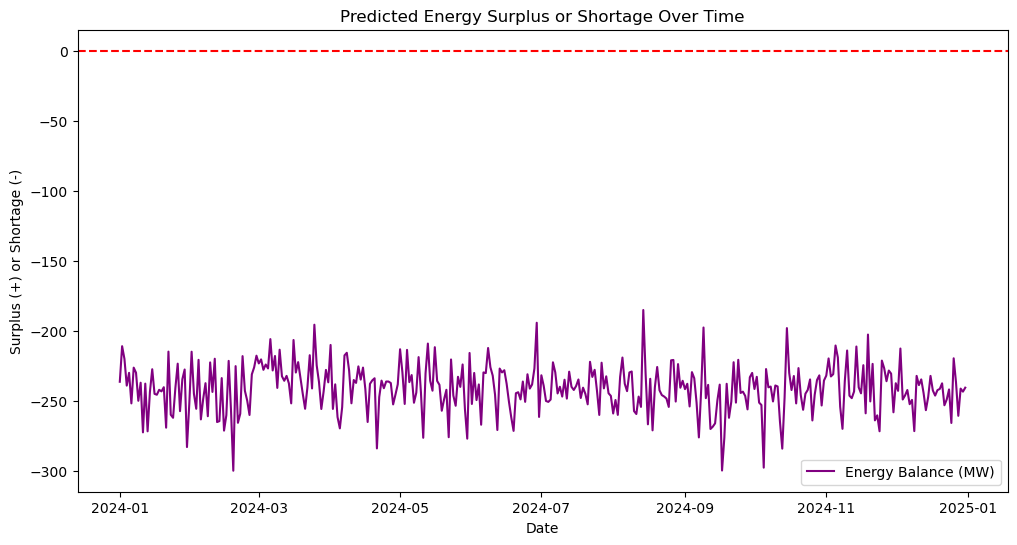

C:\Users\rah00\AppData\Local\Temp\ipykernel_16572\1758167616.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='Status', palette='Set2')


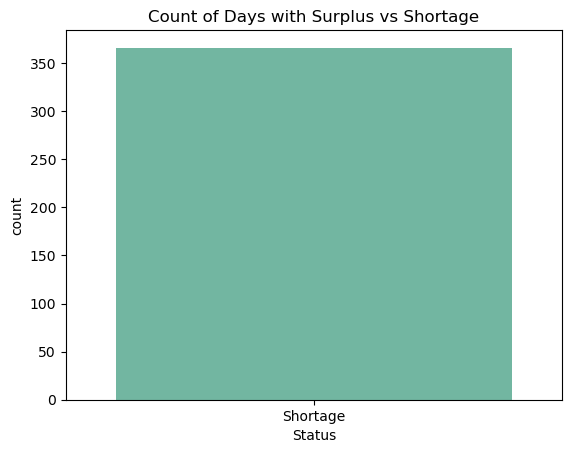

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(df['Date'], df['Energy Balance'], label='Energy Balance (MW)', color='purple')
plt.axhline(0, color='red', linestyle='--')
plt.title("Predicted Energy Surplus or Shortage Over Time")
plt.xlabel("Date")
plt.ylabel("Surplus (+) or Shortage (-)")
plt.legend()
plt.show()

# Count of Surplus vs Shortage Days
sns.countplot(data=df, x='Status', palette='Set2')
plt.title("Count of Days with Surplus vs Shortage")
plt.show()


In [ ]:

# Monthly average trend for key metrics
monthly_avg = df.groupby('Month')[['Total Renewable', 'Electric Load (MW)', 'Solar Power (MW)', 'Wind Power (MW)', 'Hydro Power (MW)']].mean()

monthly_avg.plot(kind='bar', figsize=(12,6))
plt.title("Monthly Average of Renewable Sources and Electric Load")
plt.xlabel("Month")
plt.ylabel("Average Energy (MW)")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


In [ ]:

# Boxplot to show seasonality
plt.figure(figsize=(12,6))
sns.boxplot(data=df, x='Month', y='Total Renewable')
plt.title("Seasonal Variation in Total Renewable Energy")
plt.xlabel("Month")
plt.ylabel("Total Renewable Energy (MW)")
plt.show()


In [ ]:

# Feature importance for renewable energy model
importances_A = model_A.feature_importances_
feature_names_A = X_A.columns
feature_df_A = pd.DataFrame({'Feature': feature_names_A, 'Importance': importances_A})
feature_df_A.sort_values(by='Importance', ascending=False, inplace=True)

plt.figure(figsize=(10,6))
sns.barplot(x='Importance', y='Feature', data=feature_df_A)
plt.title("Feature Importance for Renewable Energy Forecast")
plt.show()


In [ ]:

# Actual vs Predicted for Renewable Energy
plt.figure(figsize=(10, 5))
plt.plot(df['Date'], y_A, label='Actual Renewable', alpha=0.7)
plt.plot(df['Date'], df['Predicted Renewable'], label='Predicted Renewable', alpha=0.7)
plt.legend()
plt.title("Actual vs Predicted Renewable Energy")
plt.xlabel("Date")
plt.ylabel("Energy (MW)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Actual vs Predicted for Electric Load
plt.figure(figsize=(10, 5))
plt.plot(df['Date'], y_B, label='Actual Load', alpha=0.7)
plt.plot(df['Date'], df['Predicted Load'], label='Predicted Load', alpha=0.7)
plt.legend()
plt.title("Actual vs Predicted Electric Load")
plt.xlabel("Date")
plt.ylabel("Energy (MW)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [ ]:

# Color-coded timeline of Surplus vs Shortage
plt.figure(figsize=(12, 4))
colors = df['Status'].map({'Surplus': 'green', 'Shortage': 'red'})
plt.scatter(df['Date'], df['Energy Balance'], c=colors, alpha=0.6)
plt.axhline(0, linestyle='--', color='black')
plt.title("Timeline of Surplus and Shortage Days")
plt.xlabel("Date")
plt.ylabel("Energy Balance (MW)")
plt.tight_layout()
plt.show()
